## Step 1: Import processed text data, inspect data and then decide on the topics

In [2]:
# import all packages
import pandas as pd
import numpy as np

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

#!pip install gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
from gensim.models import CoherenceModel
np.random.seed(2018)
import nltk
nltk.download('wordnet')
import matplotlib.pyplot as plt
%matplotlib inline
from gensim import corpora, models

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yutinggong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv("/Users/yutinggong/Documents/github/fall2019-proj1--yutinggong/output/processed_lyrics.csv", index_col = 0)

In [4]:
df.shape

(125704, 7)

In [16]:
df.head()

,song,year,artist,genre,lyrics,id,stemmedwords
1,when-you-were-with-me,2009,a,Hip-Hop,I stopped by the house we called our home\nIt ...,1,stop house call home rundown grass overgrown s...
2,careless-whisper,2009,a,Hip-Hop,I feel so unsure\nAs I take your hand and lead...,2,unsure hand lead dance floor music die eyes ca...
3,2-59,2007,a,Hip-Hop,Mark:] Sunday football I got boot off the pitc...,3,mark sunday football boots pitch people gamble...
4,power-of-desire,2007,a,Hip-Hop,[Chris:] Fallin' for a fantasy\nI threw away m...,4,chris fallin fantasy threw destiny stop feelin...
5,you-re-not-in-love,2007,a,Hip-Hop,something in the way we touch\nyou hold my han...,5,touch hold hand hold somethings change somethi...


In [28]:
# any duplicated song names?
print(sum(df['song'].duplicated()),"number of song names are duplicated.")

31554 number of song names are duplicated.


In [41]:
# what are the years?
print('Songs span from Year', df['year'].min(), "to Year", df['year'].max())
print("\n")
print('There are total of', df['year'].nunique(), 'years.')
print("\n")
print('Top 3 years that have the most number of songs are:\n', df['year'].value_counts().head(3))

Songs span from Year 112 to Year 2016


There are total of 50 years.


Top 3 years that have the most number of songs are:
 2006    42457
2007    30600
2008     8220
Name: year, dtype: int64


In [12]:
# how many artists?
df["artist"].nunique()

2535

In [42]:
# how many genres in total?
print("There are in total of", df['genre'].nunique(), "genres")
df['genre'].value_counts()

There are in total of 12 genres


Rock             64845
Pop              18697
Metal            11311
Hip-Hop           8905
Country           7534
Jazz              4122
Not Available     3325
Electronic        2812
R&B               2174
Indie             1318
Folk               514
Other              147
Name: genre, dtype: int64

## Step 2: Wordcloud for each music genre
To do some simple exploration and visualization

In [31]:
def draw_wc(genre_df):
    text = " ".join(lyrics for lyrics in genre_df.stemmedwords)

    stopwords = set(STOPWORDS)

    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Hip-Hop


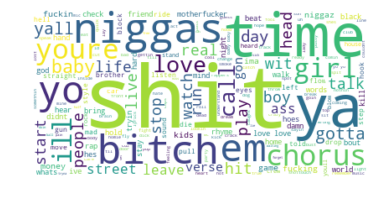

Other


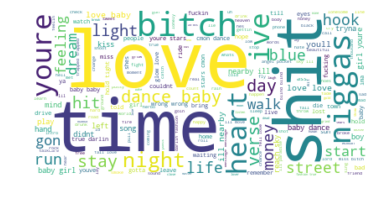

Pop


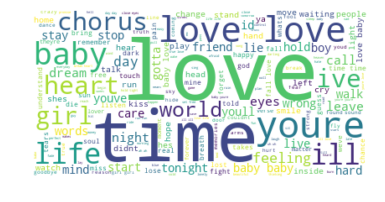

Metal


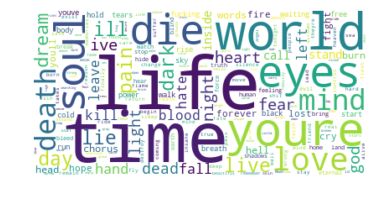

Rock


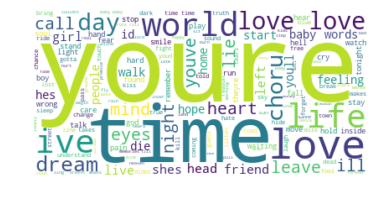

Country


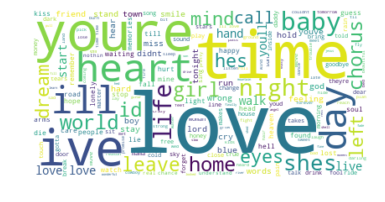

Indie


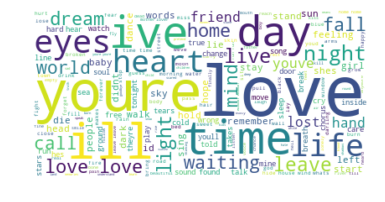

Jazz


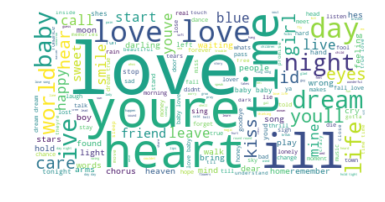

Not Available


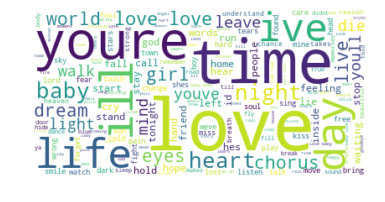

Electronic


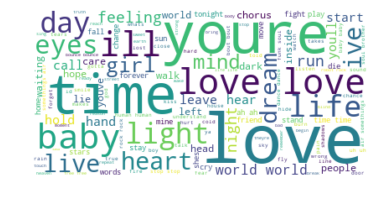

R&B


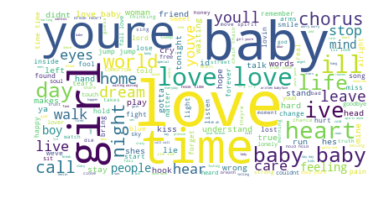

Folk


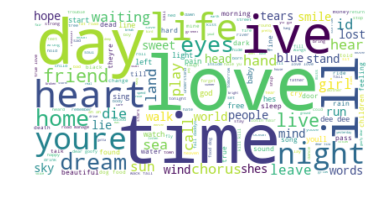

In [37]:
for genre in df["genre"].unique():
    genre_df = df[df["genre"] == genre].copy()
    print(genre)
    draw_wc(genre_df)

Based on the wordcloud, it seems like all songs like talking about "love" regardless of its music genres, except Hip-Hop, which has more dirties words such as "shit", "nigg**" and "bitch". Let's move on to Topic Modeling to see what actually are topics in each music genres.

In [145]:
# Average/mean word count by music genre
df_l = df.copy()
df_l["length"] = df["stemmedwords"].apply(lambda x:len(x.split()))

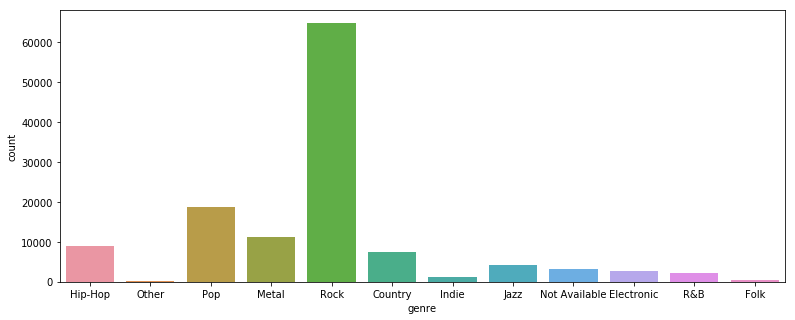

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 5))
sns.countplot(x = 'genre', data=df_l)

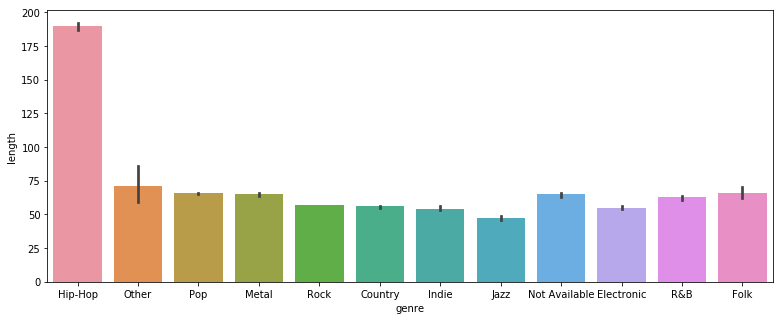

In [200]:
# word count
plt.figure(figsize=(13, 5))
sns.barplot(x="genre", y="length", data=df_l, estimator=np.median)

In [187]:
# number of unique words
def nunique_words(text):
    dic = {}
    for word in text.split():
        if word in dic:
            dic[word] += 1
        else:
            dic[word] = 1
    return dic

In [193]:
df_l["nunique_word"] = df_l["stemmedwords"].apply(lambda x: nunique_words(x))
df_l["nunique_word"] = df_l["nunique_word"].apply(lambda x:len(x))

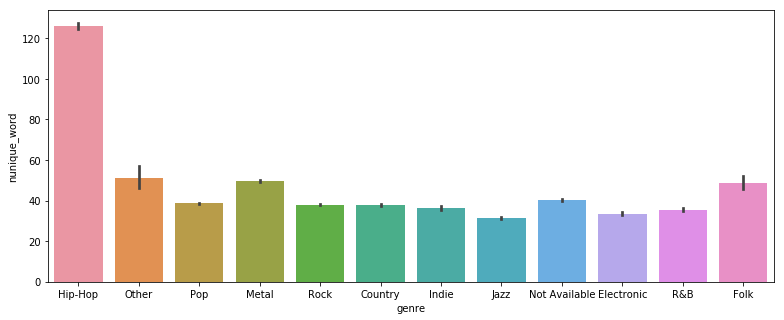

In [195]:
# number of unique words used in songs
plt.figure(figsize=(13, 5))
sns.barplot(x="genre", y="nunique_word", data=df_l)

## Step 3: Topic Modeling
When you think of a particular music genre (e.g., classic rock), do you expect certain topics or sentiments for the lyrics?

In [61]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            result.append(token)
    return result

processed_docs = df.iloc[:,-1].apply(lambda x: preprocess(x))

bigram = gensim.models.Phrases(processed_docs, min_count = 10, threshold = 50) # higher threshold fewer phrases.
bigram_doc = [bigram[line] for line in processed_docs]
bigram_doc[:3] #take a look at the first document's bigram

processed_docs = bigram_doc

#create dictionary
dictionary = gensim.corpora.Dictionary(processed_docs)

#filter tokens
print("before filter: ", len(dictionary))
dictionary.filter_extremes(no_below=15, no_above=0.8, keep_n=100000)
print("after filter: ", len(dictionary))

# create corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

before filter:  110388
after filter:  15620


In [62]:
num_topics = 10

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=2, workers=2)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.031*"shes" + 0.030*"night" + 0.026*"girl" + 0.023*"tonight" + 0.021*"boy" + 0.013*"light" + 0.011*"hes" + 0.010*"town" + 0.010*"home" + 0.009*"blue"
Topic: 1 
Words: 0.040*"youre" + 0.026*"ill" + 0.024*"time" + 0.020*"home" + 0.018*"day" + 0.016*"gotta" + 0.014*"change" + 0.014*"hold" + 0.014*"youve" + 0.013*"mind"
Topic: 2 
Words: 0.182*"love" + 0.053*"baby" + 0.045*"youre" + 0.027*"heart" + 0.017*"ill" + 0.011*"feeling" + 0.010*"hold" + 0.010*"run" + 0.010*"true" + 0.010*"girl"
Topic: 3 
Words: 0.016*"rock" + 0.014*"roll" + 0.007*"white" + 0.007*"red" + 0.007*"head" + 0.006*"black" + 0.006*"blood" + 0.006*"hand" + 0.006*"dog" + 0.006*"beautiful"
Topic: 4 
Words: 0.021*"ya" + 0.020*"shit" + 0.014*"em" + 0.013*"yo" + 0.013*"bitch" + 0.010*"niggas" + 0.008*"yall" + 0.008*"ass" + 0.007*"hit" + 0.007*"real"
Topic: 5 
Words: 0.027*"girl" + 0.022*"dance" + 0.016*"baby" + 0.015*"play" + 0.011*"youre" + 0.009*"hot" + 0.008*"bad" + 0.008*"mama" + 0.007*"world" + 0.007*"music

In [218]:
topic_dict = {}
for num in range(num_topics):
    wp = lda_model.show_topic(num)
    topic_keywords = ", ".join([word for word, prop in wp])
    topic_dict[num] = topic_keywords    

lda_corpus = [max(prob,key=lambda y:y[1])
for prob in lda_model[bow_corpus]]

In [72]:
topic = pd.DataFrame()
topic["Main Topic"] = lda_corpus
topic["Main Topic"] = topic["Main Topic"].astype(str)
new_df = topic["Main Topic"].str.split(",", n=1, expand=True)
new_df[0] = new_df[0].str[1:]
new_df[1] = new_df[1].str[:-1]
topic["Main Topic"] = pd.to_numeric(new_df[0])
topic["Probability"] = pd.to_numeric(new_df[1]).round(2)
topic["text"] = df['stemmedwords'].to_list()

df_new = pd.merge(df,topic,left_on = "stemmedwords", right_on="text", how='left')
df_new = df_new.drop(columns = ["text"])
df_new["Topic Keywords"] = df_new["Main Topic"].map(topic_dict)

In [212]:
# Topic Distribution by music genre
topic_dist = pd.DataFrame(df_new.groupby(by = ["genre","Main Topic","Topic Keywords"]).size()).reset_index()
topic_dist.rename(columns={0:"count"}, inplace=True)
topic_dist

,genre,Main Topic,Topic Keywords,count
0,Country,0,"shes, night, girl, tonight, boy, light, hes, t...",1518
1,Country,1,"youre, ill, time, home, day, gotta, change, ho...",1395
2,Country,2,"love, baby, youre, heart, ill, feeling, hold, ...",1530
3,Country,3,"rock, roll, white, red, head, black, blood, ha...",681
4,Country,4,"ya, shit, em, yo, bitch, niggas, yall, ass, hi...",54
5,Country,5,"girl, dance, baby, play, youre, hot, bad, mama...",431
6,Country,6,"god, lord, people, ride, free, money, fly, kin...",301
7,Country,7,"time, day, life, ive, dream, fall, heart, live...",2029
8,Country,8,"die, life, live, world, eyes, burn, lie, soul,...",464
9,Country,9,"sing, song, hear, ive, words, walk, sound, wai...",334


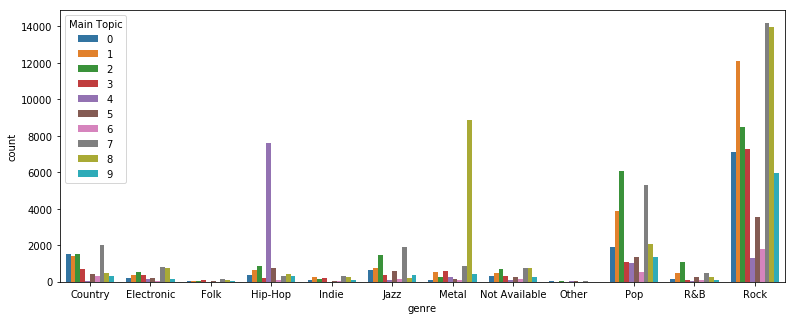

In [216]:
plt.figure(figsize=(13, 5))
sns.barplot(x="genre", y="count", hue="Main Topic", data=topic_dist, estimator=np.median)

In [219]:
topic_dict

{0: 'shes, night, girl, tonight, boy, light, hes, town, home, blue',
 1: 'youre, ill, time, home, day, gotta, change, hold, youve, mind',
 2: 'love, baby, youre, heart, ill, feeling, hold, run, true, girl',
 3: 'rock, roll, white, red, head, black, blood, hand, dog, beautiful',
 4: 'ya, shit, em, yo, bitch, niggas, yall, ass, hit, real',
 5: 'girl, dance, baby, play, youre, hot, bad, mama, world, music',
 6: 'god, lord, people, ride, free, money, fly, king, train, baby',
 7: 'time, day, life, ive, dream, fall, heart, live, ill, world',
 8: 'die, life, live, world, eyes, burn, lie, soul, dark, light',
 9: 'sing, song, hear, ive, words, walk, sound, waiting, theyre, time'}